## Importing required libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}

plt.rcParams.update(params)

## Loading and Inspecting the data

In [3]:
df = pd.read_csv("Mall_Customers.csv")

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# Renaming columns

new_col_name = {"CustomerID": "customer_id", "Gender": "gender", "Age": "age", "Annual Income (k$)": "annual_inc",
               "Spending Score (1-100)": "spending_score"}

df.rename(columns = new_col_name, inplace = True)

In [6]:
df.head()

,customer_id,gender,age,annual_inc,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_inc      200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.shape

(200, 5)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
annual_inc,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [10]:
df.describe(include = "object").T

,count,unique,top,freq
gender,200,2,Female,112


In [11]:
# Checking data for missing values

df.isna().sum()

customer_id       0
gender            0
age               0
annual_inc        0
spending_score    0
dtype: int64

In [12]:
# Dropping `customer_id` column since it is not useful in analysis and modeling

df.drop(columns = "customer_id", inplace = True)

## Exploring the data

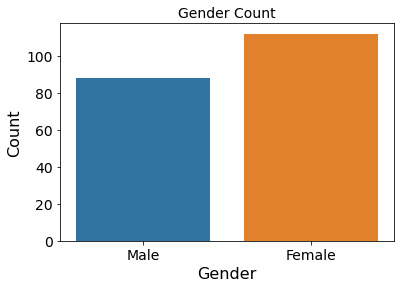

In [13]:
sns.countplot(data = df, x = "gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Count")
plt.show()

We have pretty much balanced data. Male and female are almost equal in proportion.

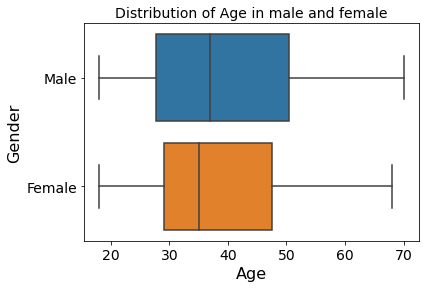

In [14]:
sns.boxplot(data = df, x = "age", y = "gender")
plt.ylabel("Gender")
plt.xlabel("Age")
plt.title("Distribution of Age in male and female")
plt.show()

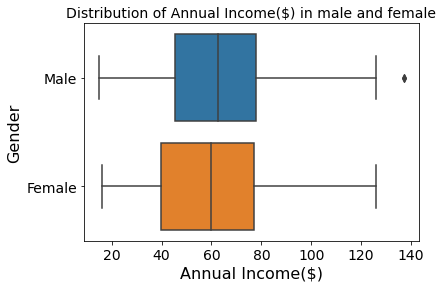

In [15]:
sns.boxplot(data = df, x = "annual_inc", y = "gender")
plt.ylabel("Gender")
plt.xlabel("Annual Income($)")
plt.title("Distribution of Annual Income($) in male and female")
plt.show()

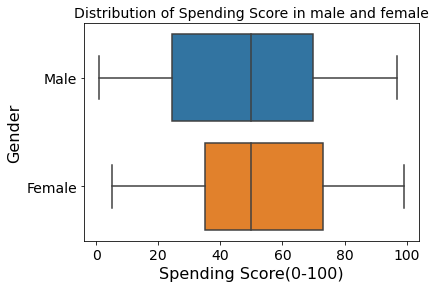

In [16]:
sns.boxplot(data = df, x = "spending_score", y = "gender")
plt.ylabel("Gender")
plt.xlabel("Spending Score(0-100)")
plt.title("Distribution of Spending Score in male and female")
plt.show()

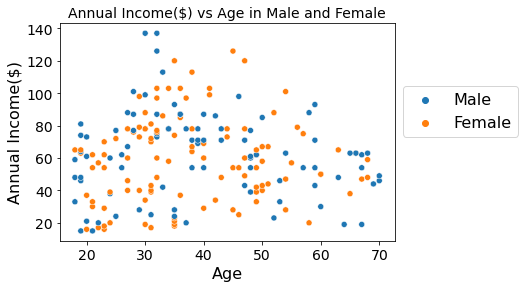

In [17]:
sns.scatterplot(data = df, x = "age", y = "annual_inc", hue = "gender")
plt.ylabel("Annual Income($)")
plt.xlabel("Age")
plt.title("Annual Income($) vs Age in Male and Female")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

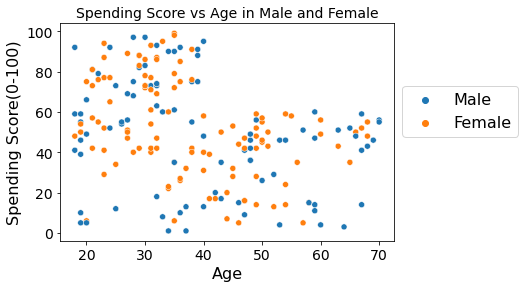

In [18]:
sns.scatterplot(data = df, x = "age", y = "spending_score", hue = "gender")
plt.ylabel("Spending Score(0-100)")
plt.xlabel("Age")
plt.title("Spending Score vs Age in Male and Female")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

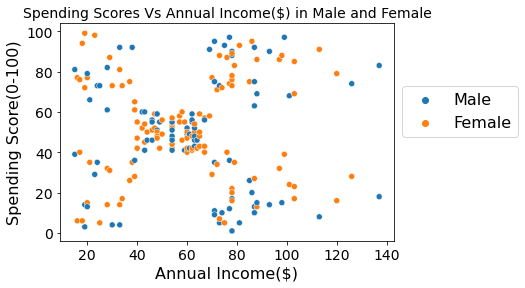

In [19]:
sns.scatterplot(data = df, x = "annual_inc", y = "spending_score", hue = "gender")
plt.ylabel("Spending Score(0-100)")
plt.xlabel("Annual Income($)")
plt.title("Spending Scores Vs Annual Income($) in Male and Female")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

We can clearly see 5 different clusters forming. So to segment the customers, we will try 5 clusters first in KMeans Clustering Algorithm.

In [20]:
# Calculating correlation between `Age`, `Annual Income` and `Spending Score`

corr = df.corr()
corr

,age,annual_inc,spending_score
age,1.000000,-0.012398,-0.327227
annual_inc,-0.012398,1.000000,0.009903
spending_score,-0.327227,0.009903,1.000000


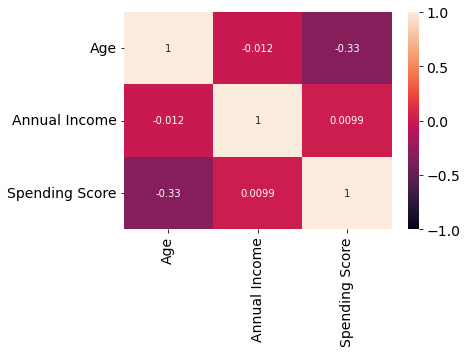

In [21]:
sns.heatmap(corr, vmin = -1, vmax = 1, annot = True, 
            xticklabels = ["Age", "Annual Income", "Spending Score"],
           yticklabels = ["Age", "Annual Income", "Spending Score"])
plt.show()

## Building the model

We will use K-Means  clustering algorithms to segment the customers into different groups.

K-Means Clustering is an Unsupervised Learning algorithm, which groups the unlabeled dataset into different clusters. Here, K defines the number of pre-defined clusters that need to be created in the process, as if K=2, there will be two clusters, and for K=3, there will be three clusters, and so on.

It is a centroid-based algorithm, where each cluster is associated with a centroid. The main aim of this algorithm is to minimize the sum of distances between the data point and their corresponding clusters.

The algorithm takes the unlabeled dataset as input, divides the dataset into k-number of clusters, and repeats the process until it does not find the best clusters. The value of K should be predetermined in this algorithm.

The K-Means clustering algorithm mainly performs two tasks:

- Determines the best value for K center points or centroids by an iterative process.
- Assigns each data point to its closest K-center. Those data points which are near to the particular K-center, create a cluster.

In [22]:
# Mapping gender to numbers, so that we can feed into the model

df["male"] = df["gender"].map({"Male": 1, "Female": 0})

In [23]:
# Features to feed into the model

features = ["age", "annual_inc", "spending_score", "male"]

In [24]:
# Training the model

model = KMeans(n_clusters = 5,random_state = 10)
model.fit(df[features])

KMeans(n_clusters=5, random_state=10)

## Exploring the results of model

Now, we have trained the model. Lets will explore the results of the model.

In [25]:
# Creating new columns `group` and storing the group labels

df["group"] = model.labels_
df["group"] = df["group"].astype("object")

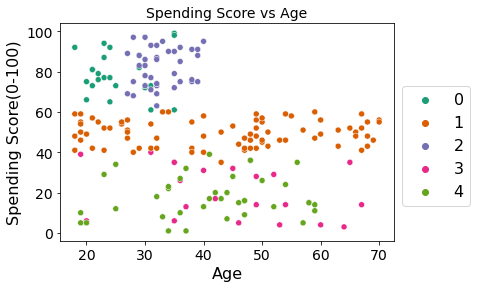

In [26]:
sns.scatterplot(data = df, x = "age", y = "spending_score", hue = "group", palette = "Dark2")
plt.ylabel("Spending Score(0-100)")
plt.xlabel("Age")
plt.title("Spending Score vs Age")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

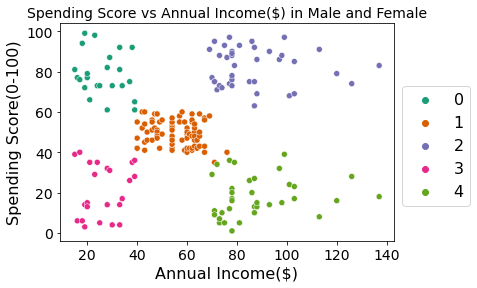

In [27]:
sns.scatterplot(data = df, x = "annual_inc", y = "spending_score", hue = "group", palette = "Dark2")
plt.ylabel("Spending Score(0-100)")
plt.xlabel("Annual Income($)")
plt.title("Spending Score vs Annual Income($) in Male and Female")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

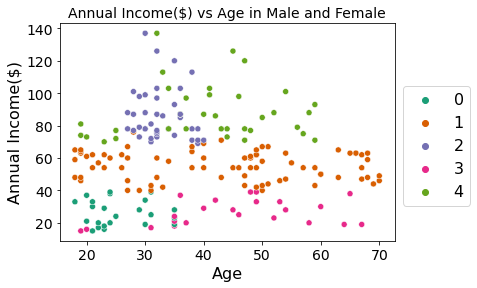

In [28]:
sns.scatterplot(data = df, x = "age", y = "annual_inc", hue = "group", palette = "Dark2")
plt.ylabel("Annual Income($)")
plt.xlabel("Age")
plt.title("Annual Income($) vs Age in Male and Female")
plt.legend(bbox_to_anchor = (1, 0.75))
plt.show()

Customers in Group 0 and 2 has high spending scores, followed by Group 1, 3 and 4. Group 0 customers has less annual income as compared to Group 2, these customers might be young and have more spending nature. But both customers in Group 0 and 2 has high spending scores. So target customers is likely the customers in Group 0 and 2.

## Clustering metrics

Clustering algorithm performance can be measure by two common metrics, **inertia and silhouette score**. These metrics will help us in determining the number of clusters to use.

### Inertia

 **Inertia** is the within-cluster sum of square distance, which is used in k-means algorithm's objective function. Mathematically, inertia is equal to

$$ \sum_{k} \sum_{X_j \in  C_k} \| X_j  - \mu_k \|^2, $$

where $\mu_k$ is the centroid of cluster $k$ and $C_k$ is the set of points assigned to cluster $k$. Basically, the inertia is the sum of the distance of each point to the centroid or center of its assigned cluster. A lower inertia means the points assigned to the clusters are closer to the centroid.

### Silhouette Score

**Silhouette Coefficient** is a measure of how dense and separated are the clusters. The silhouette coefficient is a property assigned to each data point. It's equal to

$$ \frac{b - a}{\max(a, b)}, $$

where $a$ is the distance between a point and centroid of its assigned cluster; $b$  is the distance between the point and the centroid of the nearest neighboring cluster (i.e. the closest cluster the point is not assigned to).

The silhouette coefficient ranges from -1 to 1. If a point is really close to the centroid of its assigned cluster, then $a \ll b$ and the silhouette coefficient will be approximately equal to 1. If the reverse is true, $a \gg b$, then the coefficient will be -1. If the point could have been assigned to either cluster, its coefficient will be 0.

Higher silhouette coefficient means higher density and highly separated clusters. This is because we want to have lower $a$ (close to assigned cluster's centroid) and higher $b$ (far away from unassigned cluster's centroid). A lower $a$ value combined with higher $b$ value will produce a higher silhouette score.

In [29]:
n_clusters = range(2,10)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(df[features])
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(df[features], model.labels_))

print("Inertia:", inertia_errors)
print()
print("Silhouette Scores:", silhouette_scores)

Inertia: [212889.44245524303, 143391.59236035674, 104414.67534220169, 75399.61541401484, 58348.641363315044, 51167.19736842104, 45324.850219512606, 40811.455768566826]

Silhouette Scores: [0.29307334005502633, 0.383798873822341, 0.4052954330641215, 0.4440669204743008, 0.45205475380756527, 0.43949619264530887, 0.4349105351263195, 0.4080555594955236]


### Optimizing the Number of Clusters

We can choose the optimal number of clusters by examining how number of cluster affect inertia and silhouette score. Let's check the following plots showing how inertia and silhouette scores change with respect to number of clusters ranging from 2 to 10.

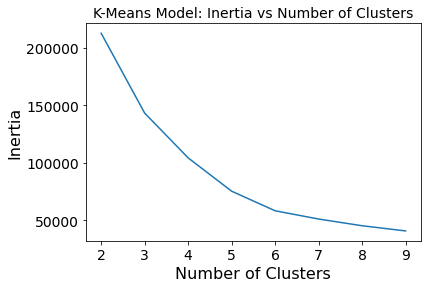

In [30]:
sns.lineplot(x = n_clusters, y = inertia_errors)
plt.xticks(range(2,10))
plt.ylabel("Inertia")
plt.xlabel("Number of Clusters")
plt.title("K-Means Model: Inertia vs Number of Clusters")
plt.show()

Note that inertia will decrease whenever the number of cluster increases. In fact, inertia will go to zero if the number of clusters equals number of data points, because each data point would be its own cluster. But that wouldn't make any practical sense, so we're not looking for the minimum point on the graph. Instead, we want the point where increasing numbers of clusters will not decrease inertia that much anymore. We usually refer to the point that indicating this change of inertia decreasing speed as the elbow point. In the example here, the elbow point is at 5-6.

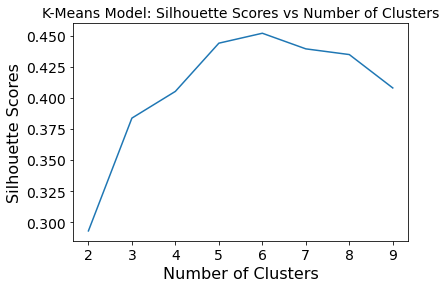

In [31]:
sns.lineplot(x = n_clusters, y = silhouette_scores, markers = ["."])
plt.xticks(range(2,10))
plt.ylabel("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.title("K-Means Model: Silhouette Scores vs Number of Clusters")
plt.show()

From the graph, we can see the silhouette score are highest at 5 and 6. Note that a higher silhouette score means denser and more clearly separated clusters, which is what we want. Combining both the inertia plot and the silhouette score plot, we can see the optimal number of cluster should be at 5.

## Conclusion

Most valuable customers to target are group 0 and 2, followed by group 1, 4 and 3. This is because customers in group 0 and 2 has high spending score and high annual income or are younger.